In [482]:
import pandas as pd
import numpy as np
import matplotlib.text
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
from typing import List, Tuple
from types import SimpleNamespace
from pathlib import Path
from configparser import ConfigParser, ExtendedInterpolation
from jpholiday import is_holiday
from PIL import Image
from matplotlib.patches import Rectangle



day_width = mdates.datestr2num("2019-09-17 00:00:00") - mdates.datestr2num("2019-09-16 00:00:00")


def get_pref_id(pref_path: Path, target_pref: List[str]) -> List[int]:
    jp_pref = pd.read_csv(pref_path, index_col=2)
    if target_pref is None or len(target_pref) == 0:
        return (jp_pref['prefecture_code'] - 1).values.tolist()
    else:
        return (jp_pref.loc[target_pref]['prefecture_code'] - 1).values.tolist()


def get_twitter(
        twitter_path: Path, data_start_date: str, data_end_date: str, area_list: List[int]
) -> np.ndarray:
    twitter = pd.read_csv(twitter_path, index_col=0)
    twitter = twitter.loc[data_start_date:data_end_date]
    twitter = twitter[area_list]
    return twitter.values
    # 全地区聚合绘制 
#     twitter = twitter.to_numpy().sum(axis =1).reshape((1728, 1))
#     twitter = np.concatenate((twitter, twitter), axis=1)
#     return twitter


def get_flow(flow_type: str, flow_path: Path, start_index: int, end_index: int, area_index: List[int]) -> np.ndarray:
#     assert flow_type in str(flow_path), 'Please check if the flow data is compatible with flow type.'
    flow = np.load(flow_path)
    # 全地区聚合绘制 
#     flow = flow.sum(axis=1).reshape((3648, 1))
#     flow = np.concatenate((flow, flow), axis=1)
    flow_pad = np.zeros((flow.shape[0], flow.shape[1] + 1))
    flow_pad[:, :flow.shape[1]] = flow
    flow_pad = flow_pad[start_index:end_index + 1, :]
    flow_pad = flow_pad[:, area_index]
    return flow_pad


def norm_data(flow_data: np.ndarray, tweet_data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    return flow_data / np.max(flow_data, axis=0), tweet_data / np.max(tweet_data, axis=0)


def select_data(
        flow_data: np.ndarray, tweet_data: np.ndarray,
        data_start_date: str, data_end_date: str, freq: str,
        target_start_date: str, target_end_date: str
) -> Tuple[np.ndarray, np.ndarray]:
    twitter_all_times = [date.strftime('%Y-%m-%d %H:%M:%S') for date in pd.date_range(
        start=data_start_date, end=data_end_date, freq=freq
    )]
    start_index = twitter_all_times.index(target_start_date)
    end_index = twitter_all_times.index(target_end_date)
    return flow_data[start_index:end_index + 1], tweet_data[start_index:end_index + 1]


def annotate_day_type(ax, ymin, ymax, date, holiday_color, weekday_color, weekend_color, zorder=0):
    if is_holiday(date):
        color = holiday_color
    elif date.weekday() in [0, 1, 2, 3, 4]:
        color = weekday_color
    else:
        color = weekend_color
    ax.add_patch(patches.Rectangle((
        mdates.datestr2num('{:d}-{:02d}-{:02d} 00:00:00'.format(date.year, date.month, date.day)), ymin),
        day_width, ymax - ymin, linewidth=0, facecolor=color, zorder=zorder
    ))

def visualize_input_time_series(args: SimpleNamespace) -> None:
    flow_all_times = [date.strftime('%Y-%m-%d %H:%M:%S') for date in pd.date_range(
        start=args.flow_start_date, end=args.flow_end_date, freq=args.input_freq
    )]
    area_index = get_pref_id(args.prefecture_filepath, args.visualize_areas)
    flow_type = args.visualize_flow_type.lower()
    flow_filepath = getattr(args, '{}_filepath'.format(flow_type))
    
    typhoon_start_index = flow_all_times.index(args.typhoon_twitter_start_date)
    typhoon_end_index = flow_all_times.index(args.typhoon_twitter_end_date)
    typhoon_flow = get_flow(flow_type, flow_filepath, typhoon_start_index, typhoon_end_index, area_index)
    typhoon_tweet = get_twitter(
        args.typhoon_tweet_filepath, args.typhoon_twitter_start_date, args.typhoon_twitter_end_date, args.visualize_areas
    )
    typhoon_img = visualize_typhoon_time_series(args, typhoon_flow, typhoon_tweet)

    figure = Image.fromarray(typhoon_img)
    figure.show()
    if args.output_path is not None and args.output_path != "":
        figure.save(args.output_path)



# 台风时序列可视化 

In [485]:
def visualize_typhoon_time_series(args: SimpleNamespace, flow_data: np.ndarray, tweet_data: np.ndarray) -> np.ndarray:
    # Preprocess data
    norm_flow_data, norm_tweet_data = norm_data(flow_data, tweet_data)
    fdata, tdata = select_data(
        norm_flow_data, norm_tweet_data, args.typhoon_twitter_start_date, args.typhoon_twitter_end_date,
        args.input_freq, args.visualize_typhoon_start_date, args.visualize_typhoon_end_date
    )
    xdata = pd.date_range(
        start=args.visualize_typhoon_start_date, end=args.visualize_typhoon_end_date, freq=args.visualize_typhoon_freq
    )

    # Generate plots
    fig = plt.figure(figsize=(args.figure_width, args.figure_height), dpi=args.figure_dpi)
    axes = fig.subplots(len(args.visualize_areas), 1, sharex=True, gridspec_kw={'hspace': 0.})
    for area_idx in range(len(args.visualize_areas)):
        ax = axes[area_idx]
        ax.plot(xdata, fdata[:, area_idx], args.flow_linecolor, lw=args.lw, label='POI Visit Count ({})'.format(args.visualize_flow_type))
        ax.plot(xdata, tdata[:, area_idx], args.tweet_linecolor, lw=args.lw, label='Disaster-Related Tweet Count')

        # Format y-axis
        ax.set_ylim([-0.07, 1.07])
        ax.set_yticks([0., 0.25, 0.5, 0.75, 1.0])
        ax.set_xticklabels(xdata, fontsize=1)
        ax.set_ylabel(args.visualize_areas[area_idx], fontweight='bold')

        ax.grid(which='major', zorder=1,color='gainsboro')

        # Annotate Day Type
        for d in pd.date_range(start=args.visualize_typhoon_start_date, end=args.visualize_typhoon_end_date, freq='1D').to_pydatetime():
            annotate_day_type(ax, -0.07, 1.07, d, args.holiday_facecolor, args.weekday_facecolor, args.weekend_facecolor)


    # Add y-label
    ylabel = fig.supylabel('Normalized Data\n(Hurricane Dorian landfall)'.format(args.visualize_flow_type),fontweight='bold', ha='center')
    ylabel.set_position((ylabel.get_position()[0] + 0.03, ylabel.get_position()[1]))

    # Format x-axis
    axes[-1].xaxis.set_major_locator(mdates.HourLocator(byhour=[0]))
    axes[-1].xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter(''))
    axes[-1].xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
    plt.setp(axes[-1].xaxis.get_minorticklabels(), rotation=30, horizontalalignment='right', rotation_mode='anchor')
    axes[-1].set_xlim([xdata[0], xdata[-1]])
    
    
    # Add legend
    days = list()
    if args.holiday_facecolor != args.weekend_facecolor or args.holiday_facecolor != args.weekday_facecolor:
        days.append(patches.Patch(edgecolor='k', facecolor=args.weekday_facecolor, label='Weekday'))
        if args.holiday_facecolor == args.weekend_facecolor:
            days.append(patches.Patch(edgecolor='k', facecolor=args.holiday_facecolor, label='Weekend or National Holiday'))
        else:
            days.append(patches.Patch(edgecolor='k', facecolor=args.holiday_facecolor, label='National Holiday'))
            days.append(patches.Patch(edgecolor='k', facecolor=args.weekend_facecolor, label='Weekend'))
        lhandles = [*axes[-1].get_legend_handles_labels()[0], *days]
    else:
        lhandles = [axes[-1].get_legend_handles_labels()[0][0], *axes[-1].get_legend_handles_labels()[0][1:][::-1]]
        
    ################## 姜总 所有 修改 看这里 #####################
    ##### 绘制竖向直线     
    for ax in axes:   
        ax.vlines(mdates.datestr2num('2019-09-01 00:00:00'), -100, 200, colors='grey', lw=1.5, linestyles='--', zorder=4)
        
    #### 绘制竖向文字 'Hurricane Dorian landfall'
    axes[0].text(0.48, 1, 'Hurricane Dorian landfall', fontweight='bold',verticalalignment ='bottom', horizontalalignment ='left', transform=axes[0].transAxes, fontsize=10)
    
    landfall_times = ['2019-09-01 00:00:00','2019-09-01 00:00:00','2019-09-02 00:00:00']
    for i, ax in enumerate(axes): 
        ax.add_patch(Rectangle((mdates.datestr2num(landfall_times[i]),  -0.5), 2, 2, facecolor="black", alpha=0.2))
        
    
    
    
    fig.legend(handles=lhandles, loc='lower center', ncol=2, bbox_to_anchor=(0.55, -0.07))

    # Extract plot as numpy
    fig.tight_layout(pad=1)
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    return img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

/home/chuang/anaconda3/envs/competitor-news/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


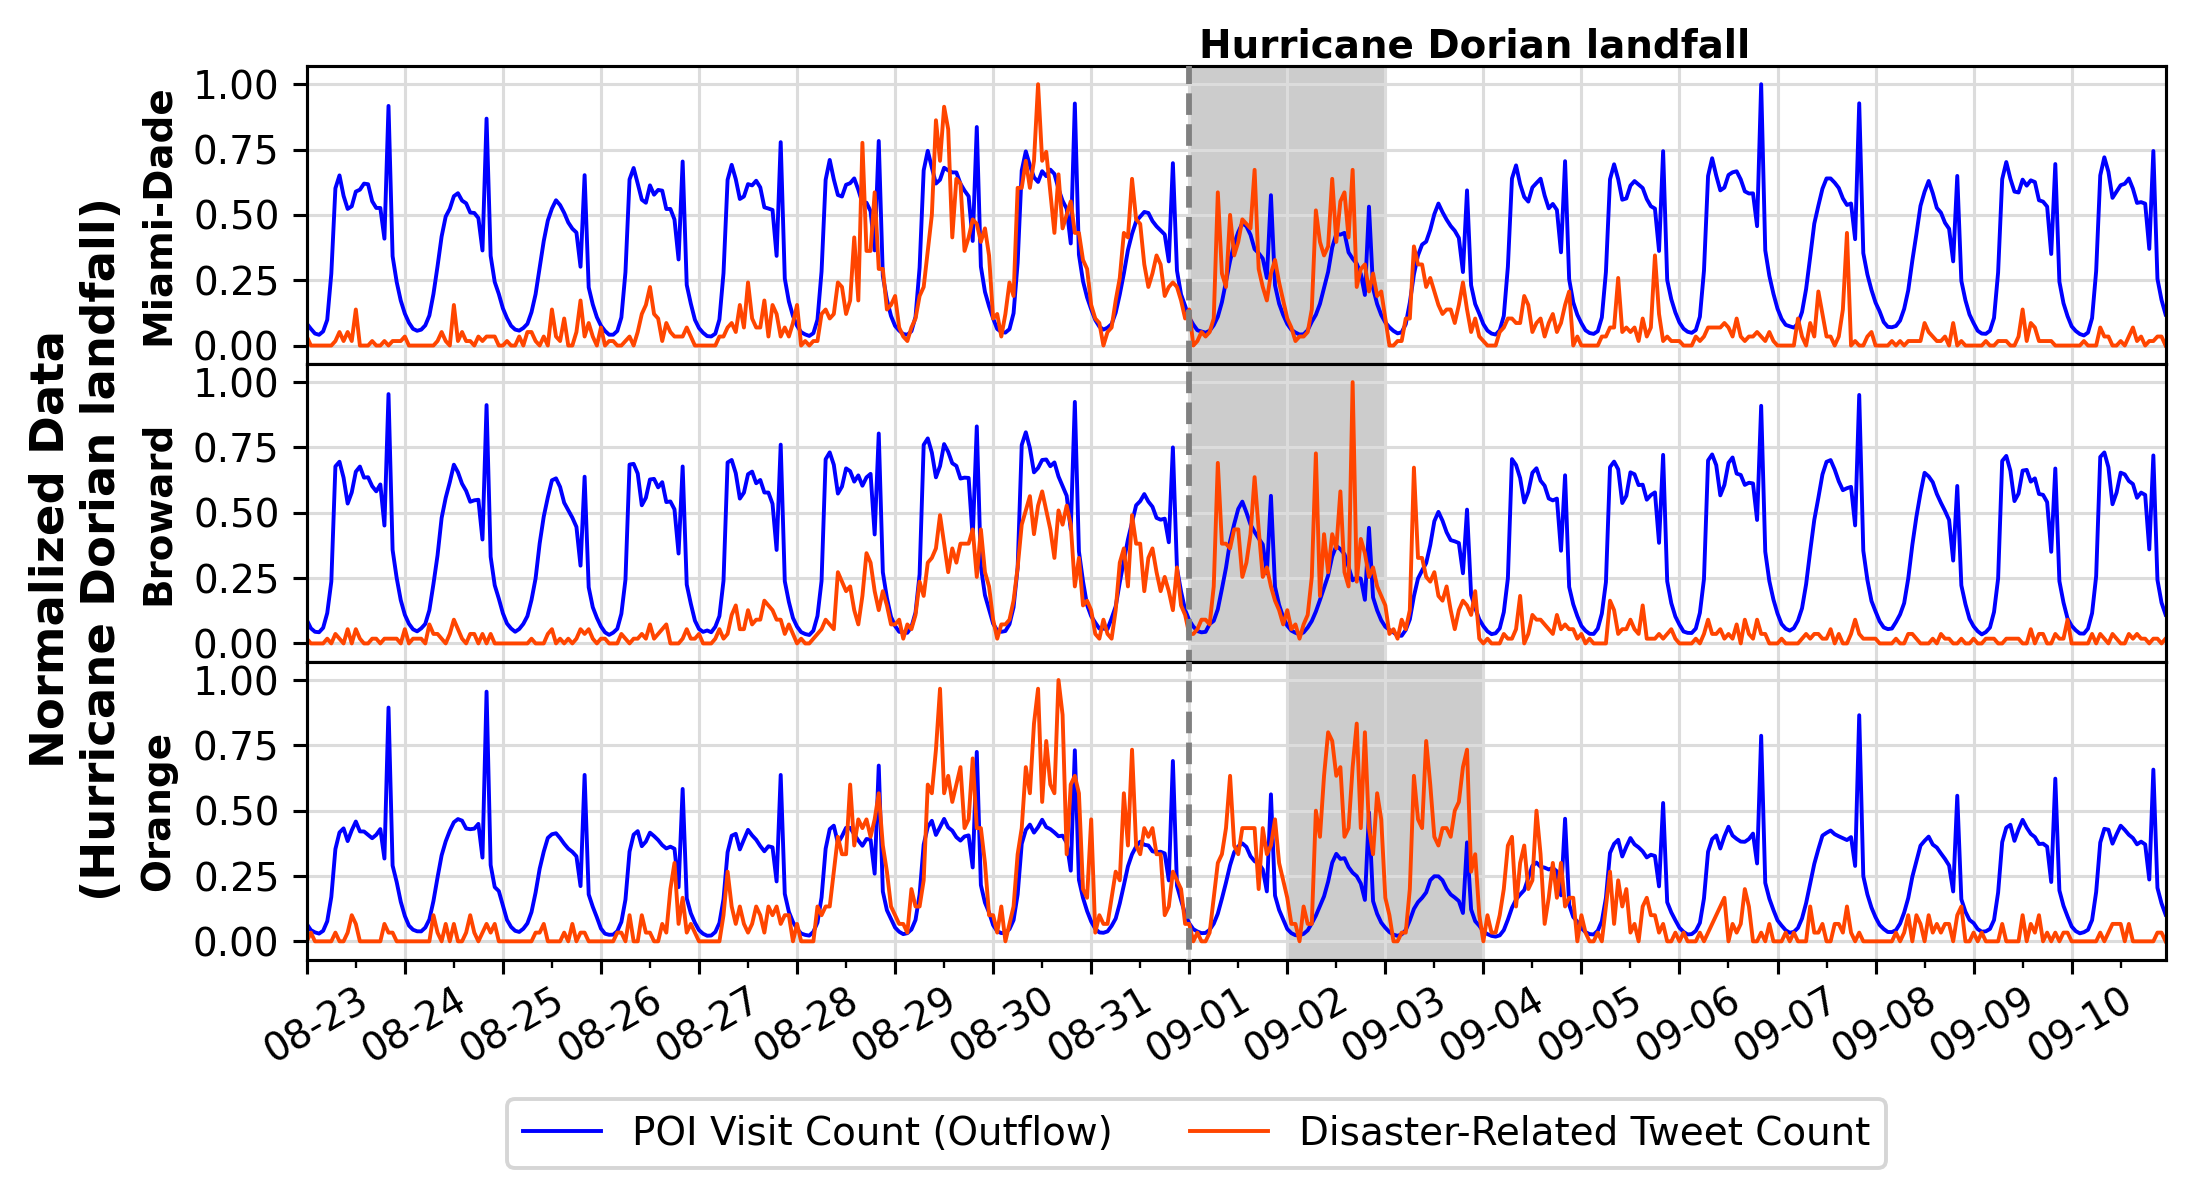

In [487]:
config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('./visualize_input_time_series_new.conf')

args = SimpleNamespace()
args.typhoon_tweet_filepath = Path(config.get('DataPath', 'typhoon_tweet_filepath'))
args.covid_tweet_filepath = Path(config.get('DataPath', 'covid_tweet_filepath'))
args.inflow_filepath = Path(config.get('DataPath', 'inflow_filepath'))
args.outflow_filepath = Path(config.get('DataPath', 'outflow_filepath'))
args.prefecture_filepath = Path(config.get('DataPath', 'prefecture_filepath'))

args.input_freq = config.get('DataDesc', 'input_freq')
args.flow_start_date = config.get('DataDesc', 'flow_start_date')
args.flow_end_date = config.get('DataDesc', 'flow_end_date')
args.typhoon_twitter_start_date = config.get('DataDesc', 'typhoon_twitter_start_date')
args.typhoon_twitter_end_date = config.get('DataDesc', 'typhoon_twitter_end_date')
args.covid_twitter_start_date = config.get('DataDesc', 'covid_twitter_start_date')
args.covid_twitter_end_date = config.get('DataDesc', 'covid_twitter_end_date')

args.visualize_flow_type = config.get('VisualizeConfig', 'visualize_flow_type')
args.visualize_areas = eval(config.get('VisualizeConfig', 'visualize_areas'))
args.visualize_typhoon_start_date = config.get('VisualizeConfig', 'visualize_typhoon_start_date')
args.visualize_typhoon_end_date = config.get('VisualizeConfig', 'visualize_typhoon_end_date')
args.visualize_typhoon_freq = config.get('VisualizeConfig', 'visualize_typhoon_freq')
args.visualize_covid_start_date = config.get('VisualizeConfig', 'visualize_covid_start_date')
args.visualize_covid_end_date = config.get('VisualizeConfig', 'visualize_covid_end_date')
args.visualize_covid_freq = config.get('VisualizeConfig', 'visualize_covid_freq')
args.figure_width = config.getint('VisualizeConfig', 'figure_width')
args.figure_height = config.getint('VisualizeConfig', 'figure_height')
args.figure_dpi = config.getint('VisualizeConfig', 'figure_dpi')
args.lw = config.getfloat('VisualizeConfig', 'linewidth')
args.flow_linecolor = config.get('VisualizeConfig', 'flow_linecolor')
args.tweet_linecolor = config.get('VisualizeConfig', 'tweet_linecolor')
args.holiday_facecolor = config.get('VisualizeConfig', 'holiday_facecolor')
args.weekday_facecolor = config.get('VisualizeConfig', 'weekday_facecolor')
args.weekend_facecolor = config.get('VisualizeConfig', 'weekend_facecolor')

args.output_path = config.get('Output', 'output_path')



visualize_input_time_series(args)